In [3]:
require(tidyverse)
require(data.table)

### 1.1 bin data

In [4]:
dat.pro_ps<- fread("../dat/1901/alpha_beta.promoter.long_matrix_w_transcripts_ps.txt")

### ps.range
ps.range <- list()
ps.range$alpha <- range((dat.pro_ps %>%filter(cluster %in% c("alpha_1","alpha_2")))$ps)
ps.range$beta <- range((dat.pro_ps %>%filter(cluster %in% c("beta_1","beta_2")))$ps)


### bins 
N.bin<- 11
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1],ps.range$alpha[2],length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1],ps.range$beta[2],length.out = N.bin)

dat.pro_ps <- rbind(
    dat.pro_ps%>% 
    filter(cluster %in% c("alpha_1","alpha_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$alpha,include.lowest = T)),
    dat.pro_ps%>% 
    filter(cluster %in% c("beta_1","beta_2"))%>%
    mutate(ps_bin =cut(ps,breaks = ps.bks$beta,include.lowest = T))
)%>%separate(cluster,into=c("celltype","subtype"))

ps.bin.dat.sum<- dat.pro_ps%>%
    select(-one_of("gene_tr.idx","ps"))%>%distinct()


setDT(ps.bin.dat.sum)
ps.bin.dat.sum<-ps.bin.dat.sum[, .(.N), by = .(ps_bin,celltype)]



ERROR: Error: Can not find symbol ps.bin.dat.sum


### 1.2 calc percent_open on bin data

In [10]:

setDT(dat.pro_ps)
dat.pro_ps <- dat.pro_ps[,.(n=.N),by=.(gene_tr.idx,celltype,ps_bin)]%>%
        left_join(ps.bin.dat.sum)%>%arrange(gene_tr.idx,ps_bin)%>%
        mutate(ps_bin.idx = as.numeric(ps_bin))%>% 
        mutate(percent_open=n/N*100)
dat.pro_ps$ps_bin.idx <- ifelse(dat.pro_ps$ps_bin.idx>10,
                                dat.pro_ps$ps_bin.idx-10,dat.pro_ps$ps_bin.idx)

Joining, by = c("celltype", "ps_bin")


#### max percnt open

In [11]:
# chisq test results 
chisq.res <- readRDS('../dat/1901/chisq_10bin_res.Rds')

dat.pro_ps.sum <- dat.pro_ps%>% 
    group_by(gene_tr.idx,celltype)%>%
    summarise(max_percent_open=max(percent_open))%>%
    left_join(rbind(chisq.res$alpha%>%mutate(celltype='alpha'),
                     chisq.res$beta%>%mutate(celltype='beta')))
head(dat.pro_ps.sum)

Joining, by = c("gene_tr.idx", "celltype")


gene_tr.idx,celltype,max_percent_open,pval,FDR,padj.Bonferroni,FDR.BY
A1BG_73417,alpha,10.0318471,4.389378e-05,0.0001163659,0.9531535,0.001229173
A1BG_73417,beta,6.7961165,6.716839e-02,0.1192666006,1.0000000,1.000000000
A1CF_13523,alpha,4.3795620,5.626573e-01,0.6041871124,1.0000000,1.000000000
A1CF_13523,beta,3.0534351,2.985542e-01,0.3804932265,1.0000000,1.000000000
A2ML1_26136,alpha,0.4761905,4.337158e-01,0.4837008618,1.0000000,1.000000000
A2ML1_26136,beta,0.4267425,4.199239e-01,0.4970725383,1.0000000,1.000000000


#### quick check + max_percent threshold + add cate

In [12]:
dat.pro_ps.sum <- (dat.pro_ps.sum%>%
    mutate(cate=ifelse(padj.Bonferroni<.01 & max_percent_open<=5,2,
                      ifelse(padj.Bonferroni<.01 & max_percent_open>5,3,
                            ifelse(padj.Bonferroni>=0.01 & max_percent_open<=5,0,1)))))

In [13]:
table(dat.pro_ps.sum[,c("celltype","cate")])

        cate
celltype     0     1     2     3
   alpha  7995  8080   190  5450
   beta   8797 11873   208   947

In [14]:
dat.pro_ps.sum <- (dat.pro_ps.sum%>%
    mutate(cate2=ifelse(padj.Bonferroni<.01 & max_percent_open<=10,2,
                      ifelse(padj.Bonferroni<.01 & max_percent_open>10,3,
                            ifelse(padj.Bonferroni>=0.01 & max_percent_open<=10,0,1)))))
table(dat.pro_ps.sum[,c("celltype","cate2")])

        cate2
celltype     0     1     2     3
   alpha 11733  4342   658  4982
   beta  13612  7058   486   669

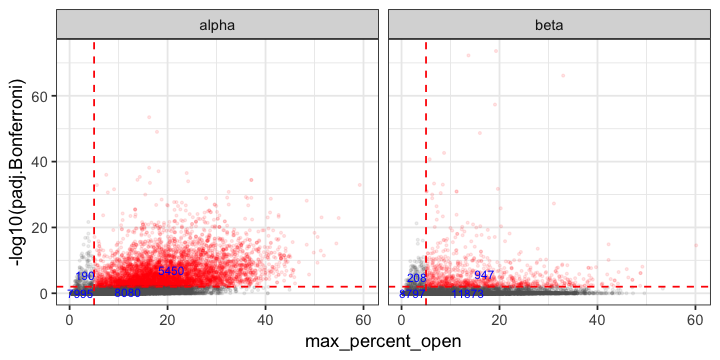

In [131]:
# https://slowkow.com/notes/ggplot2-color-by-density/
options(repr.plot.width=6, repr.plot.height=3)
require(ggplot2)
ggplot(dat.pro_ps.sum,aes(max_percent_open,-log10(padj.Bonferroni)))+
    geom_point(size=.5,alpha=.1,aes(color=as.factor(cate==3)))+
    facet_wrap(~celltype)+theme_bw()+
    scale_color_manual(values = c("grey40","red"))+
    geom_vline(xintercept = 5,color='red',linetype=2)+
    geom_hline(yintercept = 2,color='red',linetype=2)+
    theme(legend.position = "none")+
    geom_text(data=dat.pro_ps.sum %>% group_by(celltype,cate)%>%
    summarise(max_percent_open=mean(max_percent_open),
              padj.Bonferroni=10^(mean(log10(padj.Bonferroni))),
              n=n()),aes(label=n),size=2.5,color='blue')

In [188]:
dat.pro_ps.sum[grep("92628",as.character(dat.pro_ps.sum$gene_tr.idx)),]

gene_tr.idx,celltype,max_percent_open,pval,FDR,padj.Bonferroni,FDR.BY,cate
ABHD14A_92628,alpha,12.89809,1.887316e-08,9.489015e-08,0.0004098306,1.002324e-06,3
ABHD14A_92628,beta,10.38835,1.398075e-07,3.300506e-06,0.0030512981,3.487991e-05,3
ABHD14A-ACY1_92628,alpha,12.89809,1.887316e-08,9.489015e-08,0.0004098306,1.002324e-06,3
ABHD14A-ACY1_92628,beta,10.38835,1.398075e-07,3.300506e-06,0.0030512981,3.487991e-05,3
ABHD14B_92628,alpha,12.89809,1.887316e-08,9.489015e-08,0.0004098306,1.002324e-06,3
ABHD14B_92628,beta,10.38835,1.398075e-07,3.300506e-06,0.0030512981,3.487991e-05,3
ACY1_92628,alpha,12.89809,1.887316e-08,9.489015e-08,0.0004098306,1.002324e-06,3
ACY1_92628,beta,10.38835,1.398075e-07,3.300506e-06,0.0030512981,3.487991e-05,3
RP11-155D18.14_92628,alpha,12.89809,1.887316e-08,9.489015e-08,0.0004098306,1.002324e-06,3
RP11-155D18.14_92628,beta,10.38835,1.398075e-07,3.300506e-06,0.0030512981,3.487991e-05,3


In [133]:
dat.pro_ps.sum.highlight <- dat.pro_ps.sum%>% 
    filter( max_percent_open >50 | padj.Bonferroni <1e-40)%>%
    group_by(celltype)%>%
    arrange(celltype,padj.Bonferroni)
dat.pro_ps.sum.highlight

gene_tr.idx,celltype,max_percent_open,pval,FDR,padj.Bonferroni,FDR.BY,cate
FOSL1_21089,alpha,16.242038,1.507294e-58,3.273089e-54,3.273089e-54,3.457363e-53,3
ALOXE3_53509,alpha,17.834395,4.194117e-54,4.553763e-50,9.107525e-50,4.810138e-49,3
ANKRD30BL_78179,alpha,59.235669,5.657340e-38,9.302473e-35,1.228491e-33,9.826200e-34,3
HBP1_118506,alpha,51.433121,4.072435e-28,1.319894e-25,8.843292e-24,1.394204e-24,3
RIMS2_124105,alpha,54.936306,6.314873e-28,1.987355e-25,1.371275e-23,2.099242e-24,3
ZNRF2_115517,alpha,50.636943,3.550031e-22,3.456902e-20,7.708892e-18,3.651525e-19,3
ATP2B1_30772,alpha,54.458599,3.353677e-20,2.180392e-18,7.282509e-16,2.303148e-17,3
GSK3B_94343,alpha,51.273885,5.239670e-18,2.068717e-16,1.137794e-13,2.185185e-15,3
ZBTB20_94215,alpha,51.910828,1.547020e-16,4.279433e-15,3.359355e-12,4.520364e-14,3
SP4_115121,alpha,50.606796,2.410803e-14,4.238913e-13,5.235058e-10,4.477563e-12,3


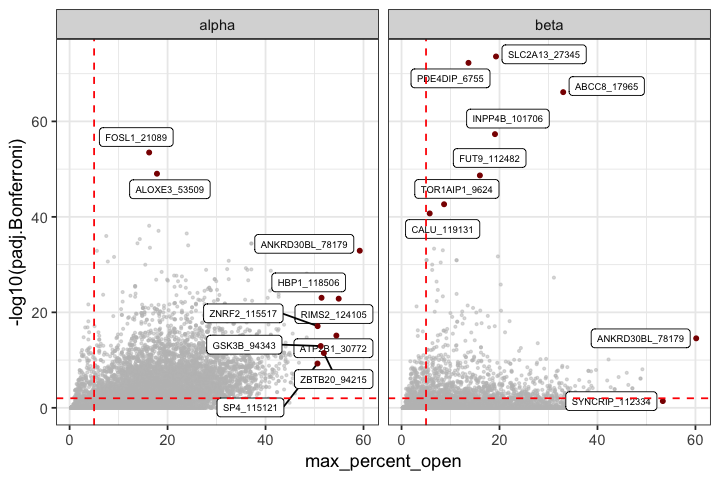

In [132]:
options(repr.plot.width=6, repr.plot.height=4)

require(gghighlight)
 dat.pro_ps.sum%>%
    ggplot(aes(max_percent_open,-log10(padj.Bonferroni)))+
    geom_point(size=.5,alpha=.5)+
    gghighlight( max_percent_open >50 | padj.Bonferroni <1e-40,
                label_key = gene_tr.idx,
               label_params=list(size = 2))+
    geom_point(col = "darkred",size=1)+
    facet_wrap(~celltype)+theme_bw()+
    geom_vline(xintercept = 5,color='red',linetype=2)+
    geom_hline(yintercept = 2,color='red',linetype=2)

Joining, by = c("gene_tr.idx", "celltype")


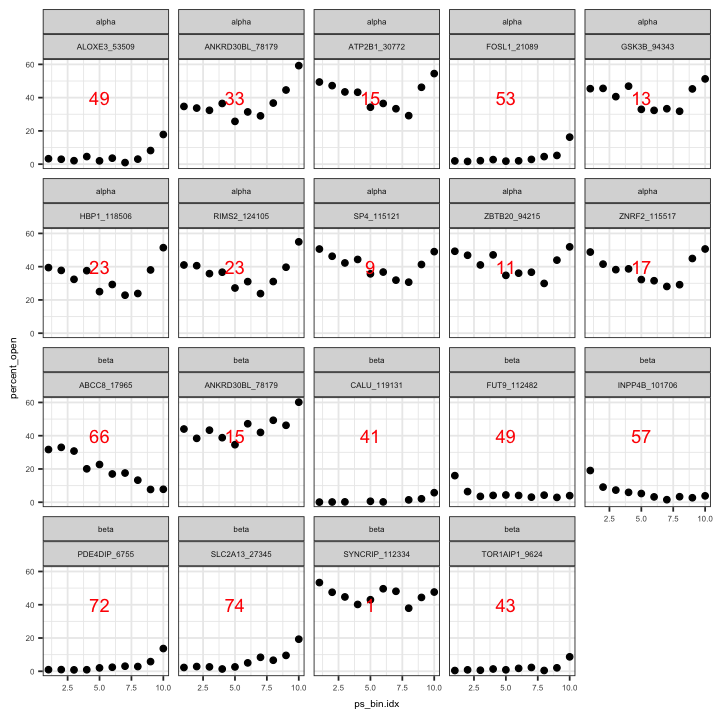

In [151]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(dat.pro_ps%>%inner_join(dat.pro_ps.sum.highlight),
       aes(ps_bin.idx,percent_open))+
    geom_point()+facet_wrap(celltype~gene_tr.idx)+theme_bw()+
    theme(text = element_text(size = 6))+
    geom_text(data = dat.pro_ps.sum.highlight%>%mutate(ps_bin.idx=5,percent_open=40),
        aes(label=round(-log10(padj.Bonferroni))),color='red')


## 2. add max_percent_open filter

In [158]:
# inital glist 
all.glist.old <- readRDS('../dat/1901/all.list.Rds')

In [163]:
t(lapply(all.glist.old[[1]],length))
t(lapply(all.glist.old[[2]],length))
table((dat.pro_ps.sum%>% filter(cate==3))$celltype)

binary.alpha_tr,binary.beta_tr,dynamical.alpha_tr,dynamical.beta_tr
2227,878,5640,1155


binary.alpha,binary.beta,dynamical.alpha,dynamical.beta
2146,860,5293,1103



alpha  beta 
 5450   947 

In [219]:
dy.glist<- sapply(c("alpha","beta"),function(x)
    subset(dat.pro_ps.sum,celltype==x & cate==3)$gene_tr.idx
)
names(dy.glist)<- c("alpha_tr","beta_tr")
dy.glist$alpha <- unique(sapply(dy.glist$alpha,function(x) unlist(strsplit(x,split="_"))[1]))
dy.glist$beta <- unique(sapply(dy.glist$beta,function(x) unlist(strsplit(x,split="_"))[1]))
t(lapply(dy.glist,length))

alpha_tr,beta_tr,alpha,beta
5450,947,5172,918


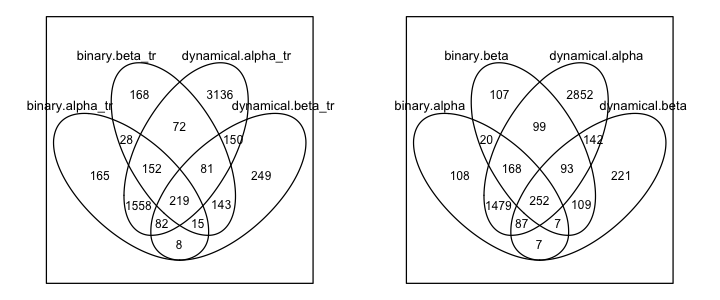

In [220]:
options(repr.plot.width=6, repr.plot.height=2.5)
par(mfrow=c(1,2))
all.list.tr <- list(binary.alpha_tr= c(binary.glist$alpha1_tr,binary.glist$alpha2_tr),
                 binary.beta_tr=c(binary.glist$beta1_tr,binary.glist$beta2_tr),
                 dynamical.alpha_tr=dy.glist$alpha_tr,
                 dynamical.beta_tr=dy.glist$beta_tr)
all.list.gene <- list(binary.alpha= c(binary.glist$alpha1,binary.glist$alpha2),
                 binary.beta=c(binary.glist$beta1,binary.glistb$beta2),
                 dynamical.alpha=dy.glist$alpha,
                 dynamical.beta=dy.glist$beta)
venn(all.list.tr,ellipse = T,cexsn =.65 )
venn(all.list.gene,ellipse = T,cexsn = .65)

In [221]:
saveRDS(dy.glist,'../dat/1901/dy.glist.Rds')

##  clustering

In [181]:

pd <- (dat.pro_ps%>%
     inner_join(dat.pro_ps.sum%>%filter(cate==3&celltype=="beta"))%>%
    select(one_of("gene_tr.idx","ps_bin.idx","percent_open"))%>%
    spread(key=ps_bin.idx,value=percent_open)%>%
    column_to_rownames("gene_tr.idx"))


Joining, by = c("gene_tr.idx", "celltype")


[1] 947  10

,1,2,3,4,5,6,7,8,9,10
ABCB6_81071,0.5026596,0.4826458,0.6408482,0.2085616,0.3793605,0.7728641,0.3486641,0.4020142,0.6904046,1.0000000
ABCB9_32876,0.5965630,0.4283838,0.7473487,0.3437829,0.5252683,0.8332898,0.5172490,0.7849982,0.9840608,1.0000000
ABCC8_17965,0.9604068,1.0000000,0.9326056,0.6088018,0.6870740,0.5148351,0.5320150,0.4021082,0.2326066,0.2360671
ABCC8_17971,0.9042854,0.8897135,1.0000000,0.6300046,0.6149871,0.6429717,0.5617141,0.6538911,0.3816626,0.3994052
ABHD14A_92628,0.5014365,0.5203334,0.8240890,0.1758204,0.4477288,1.0000000,0.6613398,0.8211897,0.5991391,0.8728709
ABHD14A-ACY1_92628,0.5014365,0.5203334,0.8240890,0.1758204,0.4477288,1.0000000,0.6613398,0.8211897,0.5991391,0.8728709


[1] 841  10

2  clusters  0.3270212 
3  clusters  0.319253 
4  clusters  0.2510894 
5  clusters  0.238395 
6  clusters  0.1887117 
7  clusters  0.1604024 
8  clusters  0.1632196 
9  clusters  0.1458721 
10  clusters  0.1300677 



  1   2 
581 260 

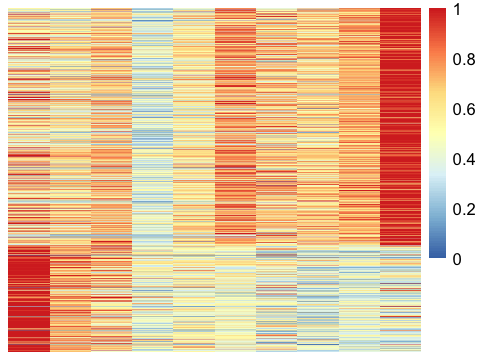

In [223]:
options(repr.plot.width=4, repr.plot.height=3)

require(fpc)
dat.sub.2.scale <- t(apply(pd,1,function(x) x/max(x)))
dim(dat.sub.2.scale)
head(dat.sub.2.scale)
dat.sub.2.scale <- dat.sub.2.scale %>% as.data.frame() %>% distinct()
dim(dat.sub.2.scale)
dat.sub.2.scale[is.na(dat.sub.2.scale)]<-0 
                           
pk.scale<- pamk(dat.sub.2.scale,critout=T)
table(pk.scale$pamobject$clustering)
pheatmap(dat.sub.2.scale[order(pk.scale$pamobject$clustering),],scale="none",cluster_rows = F,cluster_cols = F,
         show_rownames = F,show_colnames = F)

In [183]:
head(pd)

,1,2,3,4,5,6,7,8,9,10
ABCB6_81071,7.703595,7.396871,9.821429,3.196347,5.813953,11.844660,5.343511,6.161137,10.580913,15.325670
ABCB9_32876,7.923698,5.689900,9.926471,4.566210,6.976744,11.067961,6.870229,10.426540,13.070539,13.282248
ABCC8_17965,31.694791,33.001422,30.777311,20.091324,22.674419,16.990291,17.557252,13.270142,7.676349,7.790549
ABCC8_17971,9.831255,9.672831,10.871849,6.849315,6.686047,6.990291,6.106870,7.109005,4.149378,4.342273
ABHD14A_92628,5.209098,5.405405,8.560924,1.826484,4.651163,10.388350,6.870229,8.530806,6.224066,9.067688
ABHD14A-ACY1_92628,5.209098,5.405405,8.560924,1.826484,4.651163,10.388350,6.870229,8.530806,6.224066,9.067688
